 Pré-processamento de Dados

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

filename = "Salary_Dataset.csv"
df_dirty = pd.read_csv(filename)

df_dirty.head()

,Company Name,Job Title,Salaries Reported,Location,Salary
0,Mu Sigma,Data Scientist,105.0,Bangalore,"₹6,48,573/yr"
1,IBM,Data Scientist,95.0,Bangalore,"₹11,91,950/yr"
2,Tata Consultancy Services,Data Scientist,66.0,Bangalore,"₹8,36,874/yr"
3,Impact Analytics,Data Scientist,40.0,Bangalore,"₹6,69,578/yr"
4,Accenture,Data Scientist,32.0,Bangalore,"₹9,44,110/yr"


In [5]:
df_dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4344 entries, 0 to 4343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company Name       4341 non-null   object 
 1   Job Title          4344 non-null   object 
 2   Salaries Reported  4342 non-null   float64
 3   Location           4344 non-null   object 
 4   Salary             4344 non-null   object 
dtypes: float64(1), object(4)
memory usage: 169.8+ KB


In [39]:
df_dirty.isnull().sum()

Company Name         3
Job Title            0
Salaries Reported    2
Location             0
Salary               0
dtype: int64

In [8]:
df_dirty[df_dirty["Salaries Reported"].isnull()]

,Company Name,Job Title,Salaries Reported,Location,Salary
4027,First Student Data Scientist,Data Analyst,NaN,Pune,"₹4,53,300/yr"
4237,Amazon,Machine Learning Data Associate II,NaN,New Delhi,"₹3,29,439/yr"


In [59]:
df_dirty[df_dirty["Company Name"].isnull()]

#novel_df = df;
#novel_df['Cabin'] = novel_df['Cabin'].fillna('NOCABIN')

,Company Name,Job Title,Salaries Reported,Location,Salary
2279,NaN,Data Analyst,1.0,Pune,"₹23,500/mo"
3227,NaN,Data Engineer,1.0,Pune,"₹26,20,604/yr"
4026,NaN,Machine Learning Engineer/Data Scientist,1.0,Pune,"₹56,465/mo"


In [3]:
df = df_dirty.dropna(axis='rows')
df = df[df["Salaries Reported"].notnull()].copy()
df = df[df["Company Name"].notnull()].copy()

df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 0 to 4343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company Name       4339 non-null   object 
 1   Job Title          4339 non-null   object 
 2   Salaries Reported  4339 non-null   float64
 3   Location           4339 non-null   object 
 4   Salary             4339 non-null   object 
dtypes: float64(1), object(4)
memory usage: 203.4+ KB


Company Name         0
Job Title            0
Salaries Reported    0
Location             0
Salary               0
dtype: int64

In [5]:
print(f"Number of unique job titles: {df['Job Title'].nunique()}")
print("Unique job titles:")

job_counts = df['Job Title'].value_counts().reset_index()
job_counts.columns = ['Job Title', 'Count']

job_counts

Number of unique job titles: 25
Unique job titles:


,Job Title,Count
0,Data Scientist,1844
1,Data Analyst,988
2,Data Engineer,804
3,Machine Learning Engineer,568
4,Data Science,43
5,Senior Data Scientist,39
6,Junior Data Scientist,18
7,Senior Machine Learning Engineer,9
8,Lead Data Scientist,6
9,Machine Learning Consultant,2


In [6]:
import pandas as pd
import re
from tabulate import tabulate

# Exemplo: carregando o DataFrame (use seu próprio dataset)
# df = pd.read_csv("salarios.csv")

# Taxas de câmbio para conversão para USD
TAXAS_CAMBIO = {
    '₹': 83.0,    # INR para USD
    '$': 1.0,     # USD (já está em dólar)
    '£': 0.92,    # EUR para USD (1 EUR ≈ 1/0.92 USD)
    'AFN': 71.0   # AFN para USD (1 AFN ≈ 1/71 USD)
}

# Função para converter salário para USD anual
def converter_para_usd_anual(salario_str):
    if pd.isnull(salario_str):
        return None

    # Detectar símbolo de moeda
    moeda = None
    for simbolo in TAXAS_CAMBIO:
        if simbolo in salario_str:
            moeda = simbolo
            break

    if moeda is None:
        return None

    # Remover símbolo e vírgulas
    salario_str_limpo = salario_str.replace(moeda, '').replace(',', '').strip()

    # Extrair número e unidade (/yr, /mo, etc.)
    match = re.match(r"(\d+)(?:/(\w+))?", salario_str_limpo)
    if not match:
        return None

    valor = int(match.group(1))
    unidade = match.group(2)

    # Converter para salário anual
    if unidade == 'mo':
        valor *= 12
    elif unidade == 'hr':
        valor *= 2080  # 52 semanas * 40h

    # Converter para USD
    taxa = TAXAS_CAMBIO[moeda]
    valor_usd = valor / taxa
    return round(valor_usd, 2)

# Criar nova coluna com salário em USD
df["Salary_usd"] = df["Salary"].apply(converter_para_usd_anual)

print("12 Maiores Salarios do Dataset")
df.sort_values(by="Salary_usd", ascending=False).head(12)
df                                                


12 Maiores Salarios do Dataset


,Company Name,Job Title,Salaries Reported,Location,Salary,Salary_usd
0,Mu Sigma,Data Scientist,105.0,Bangalore,"₹6,48,573/yr",7814.13
1,IBM,Data Scientist,95.0,Bangalore,"₹11,91,950/yr",14360.84
2,Tata Consultancy Services,Data Scientist,66.0,Bangalore,"₹8,36,874/yr",10082.82
3,Impact Analytics,Data Scientist,40.0,Bangalore,"₹6,69,578/yr",8067.20
4,Accenture,Data Scientist,32.0,Bangalore,"₹9,44,110/yr",11374.82
...,...,...,...,...,...,...
4339,TaiyōAI,Machine Learning Scientist,1.0,Mumbai,"₹5,180/mo",748.92
4340,Decimal Point Analytics,Machine Learning Developer,1.0,Mumbai,"₹7,51,286/yr",9051.64
4341,MyWays,Machine Learning Developer,1.0,Mumbai,"₹4,10,952/yr",4951.23
4342,Market Pulse Technologies,Software Engineer - Machine Learning,1.0,Mumbai,"₹16,12,324/yr",19425.59


In [7]:
print("12 Menores Salarios do Dataset")
df.sort_values(by="Salary_usd", ascending=True).head(12)

12 Menores Salarios do Dataset


,Company Name,Job Title,Salaries Reported,Location,Salary,Salary_usd
2471,Orbit Technologies,Data Analyst,1.0,Hyderabad,"₹10,814/yr",130.29
3873,20K Group,Machine Learning Engineer,1.0,Bangalore,"₹21,628/yr",260.58
2288,Fran Biz,Data Analyst,1.0,Pune,"₹2,010/mo",290.60
2490,Wipro Technologies,Data Analyst,1.0,Hyderabad,"₹2,063/mo",298.27
2248,Friends Union for Energising Lives (Fuel),Data Analyst,2.0,Pune,"₹2,460/mo",355.66
2740,Blackcoffer,Data Analyst,2.0,New Delhi,"₹3,084/mo",445.88
2814,iAastha,Data Analyst,2.0,Mumbai,"₹3,278/mo",473.93
2921,20K Group,Data Analyst,1.0,Mumbai,"₹42,892/yr",516.77
4333,Knowledge Solutions India,Machine Learning Engineer,1.0,Mumbai,"₹3,762/mo",543.90
4143,Azure Skynet,Machine Learning Engineer,1.0,Hyderabad,"₹4,144/mo",599.13


In [8]:
# Filtrar apenas linhas com moedas diferentes de ₹ (ou seja, moeda ≠ '₹')
linhas_nao_inr = df[df["Salary"].apply(lambda x: '₹' not in str(x))]

print("Os Salarios em moedas diferentes de ₹")
# Exibir resultado
linhas_nao_inr[["Company Name", "Job Title","Location","Salaries Reported", "Salary", "Salary_usd"]].sort_values(by="Salary_usd", ascending=False)

Os Salarios em moedas diferentes de ₹


,Company Name,Job Title,Location,Salaries Reported,Salary,Salary_usd
585,MiQ,Data Scientist,Bangalore,1.0,"£16,74,802/yr",1820436.96
3407,Cognizant Technology Solutions,Data Engineer,Hyderabad,1.0,"£1,00,000/mo",1304347.83
3285,Datametica,Data Engineer,Pune,1.0,"£10,15,458/yr",1103758.70
1115,Saama Technologies,Data Scientist,Pune,1.0,"£9,34,857/yr",1016148.91
3419,Cognizant Technology Solutions,Data Engineer,Hyderabad,1.0,"$8,20,000/yr",820000.00
1054,Tata Consultancy Services,Data Scientist,Pune,1.0,"£7,03,427/yr",764594.57
1865,DONE by NONE,Data Scientist,Mumbai,1.0,"$50,367/mo",604404.00
1869,Bharti Airtel,Data Scientist,Mumbai,1.0,"$6,04,401/yr",604401.00
2486,Genpact,Data Analyst,Hyderabad,1.0,"$5,13,690/yr",513690.00
658,Infosys,Data Scientist,Bangalore,1.0,"$5,11,613/yr",511613.00


In [66]:
contagem_hr = df['Salary'].str.contains('/hr', na=False).sum()
contagem_mo = df['Salary'].str.contains('/mo', na=False).sum()
contagem_yr = df['Salary'].str.contains('/yr', na=False).sum()

print("Contagem por tipo de unidade salarial:")
print(f"/hr: {contagem_hr} salários por hora")
print(f"/mo: {contagem_mo} salários por mês")
print(f"/yr: {contagem_yr} salários por ano")
print()

# === 2. Filtrar linhas com salários mensais (/mo) ===
salarios_hr = df[df['Salary'].str.contains('/hr', na=False)]

print("Salários por hora /hr")
# === 3. Exibir os resultados filtrados ===
salarios_hr[["Company Name", "Job Title", "Location", "Salary","Salary_usd"]].sort_values(by="Salary_usd", ascending=False)

Contagem por tipo de unidade salarial:
/hr: 22 salários por hora
/mo: 1088 salários por mês
/yr: 3229 salários por ano

Salários por hora /hr


,Company Name,Job Title,Location,Salary,Salary_usd
3876,Turing.com,Machine Learning Engineer,Bangalore,$62/hr,128960.00
4062,Meta,Machine Learning Engineer,Hyderabad,"₹3,017/hr",75606.75
3671,Larvol Group,Data Engineer,Mumbai,$26/hr,54080.00
1066,Persistent Systems,Data Scientist,Pune,"₹2,141/hr",53653.98
190,Simplilearn Solutions,Data Scientist,Bangalore,"₹1,587/hr",39770.60
814,Freelancer,Data Scientist,Bangalore,"₹1,507/hr",37765.78
478,Toptal,Data Scientist,Bangalore,"₹1,500/hr",37590.36
2430,HSBC,Data Analyst,Hyderabad,"₹1,263/hr",31651.08
1891,upGrad,Data Scientist,Mumbai,"₹1,027/hr",25736.87
912,Google,Data Scientist,Bangalore,"₹1,000/hr",25060.24


C:\Users\danie\AppData\Local\Temp\ipykernel_16800\254960177.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\danie\AppData\Local\Temp\ipykernel_16800\254960177.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\danie\AppData\Local\Temp\ipykernel_16800\254960177.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\danie\AppData\Local\Temp\ipykernel_16800\254960177.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` 

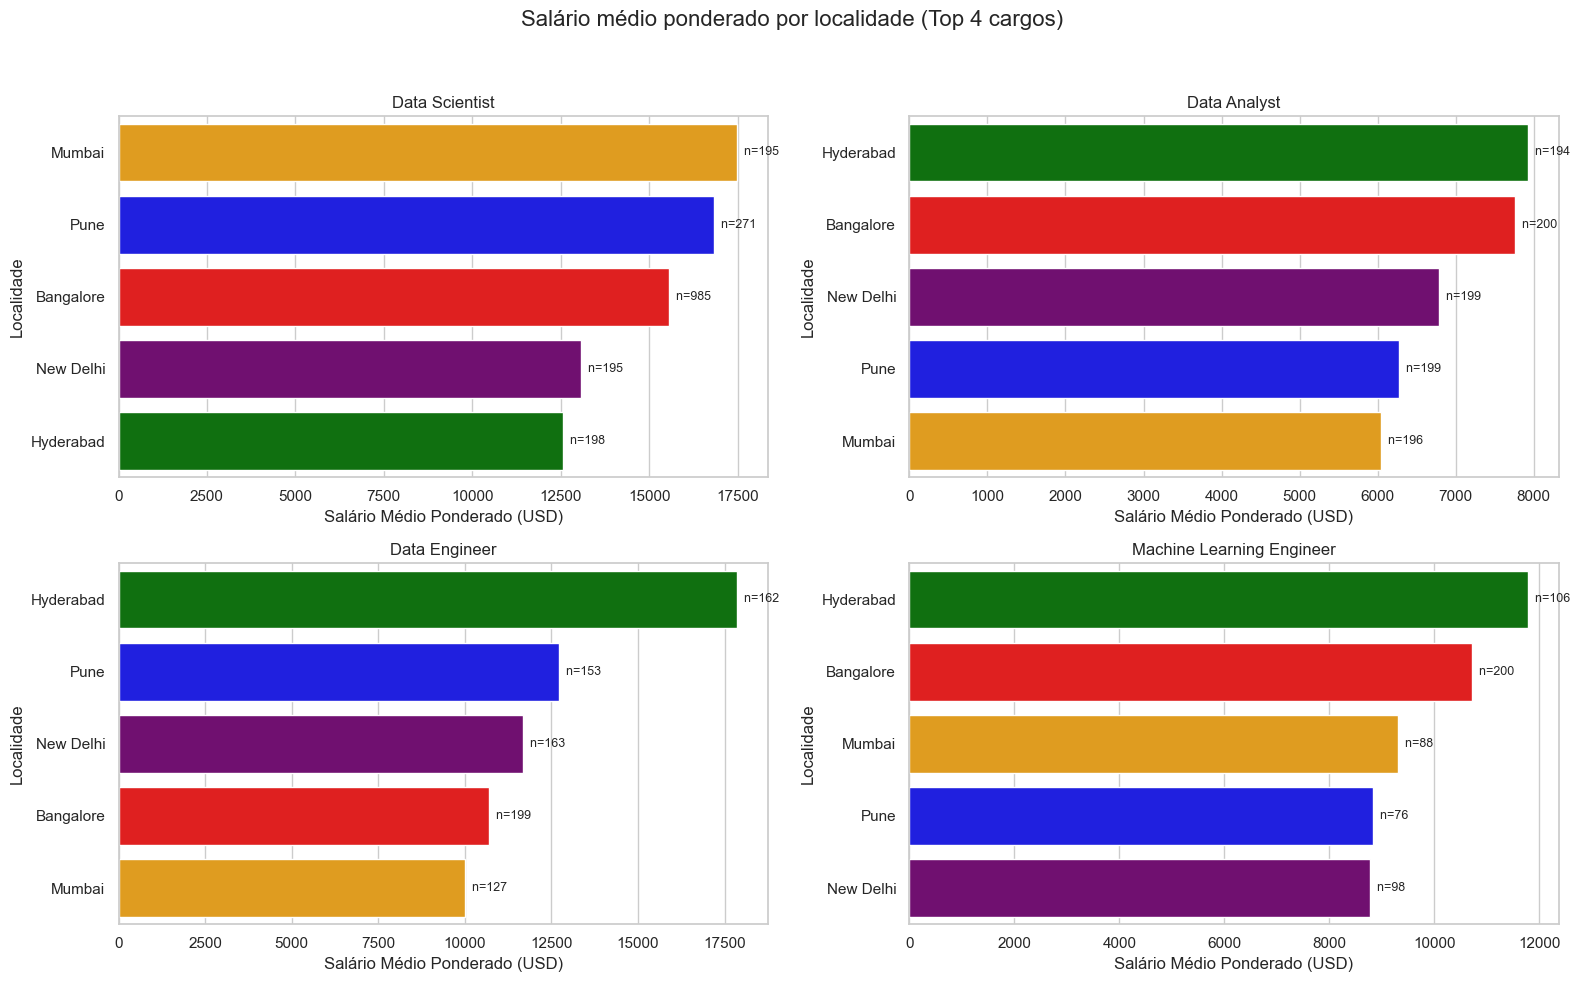

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo dos gráficos
sns.set(style="whitegrid")

# Selecionar os 4 job titles mais frequentes
top_job_titles = df["Job Title"].value_counts().nlargest(4).index.tolist()

# Gerar cores fixas para localizações
todas_cidades = df["Location"].unique()
cores_fixas = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'gray']
mapa_cores = {cidade: cores_fixas[i % len(cores_fixas)] for i, cidade in enumerate(todas_cidades)}

# Criar subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Salário médio ponderado por localidade (Top 4 cargos)", fontsize=16)

for i, job in enumerate(top_job_titles):
    df_job = df[df["Job Title"] == job].copy()

    # Calcular salário ponderado e total de pesos por localidade
    df_job["Salario_Ponderado"] = df_job["Salary_usd"] * df_job["Salaries Reported"]
    agrupado = df_job.groupby("Location").agg(
        salario_total=('Salario_Ponderado', 'sum'),
        peso_total=('Salaries Reported', 'sum'),
        amostras=('Salary_usd', 'count')
    )
    agrupado["Media_Ponderada"] = agrupado["salario_total"] / agrupado["peso_total"]

    # Ordenar por média
    agrupado = agrupado.sort_values("Media_Ponderada", ascending=False)

    # Cores consistentes por cidade
    cores = [mapa_cores[cidade] for cidade in agrupado.index]

    # Subplot correto
    ax = axes[i // 2, i % 2]

    # Plotar gráfico
    sns.barplot(
        x=agrupado["Media_Ponderada"],
        y=agrupado.index,
        palette=cores,
        ax=ax
    )

    ax.set_title(job)
    ax.set_xlabel("Salário Médio Ponderado (USD)")
    ax.set_ylabel("Localidade")

    # Adicionar número de amostras em cada barra
    for j, (media, n) in enumerate(zip(agrupado["Media_Ponderada"], agrupado["amostras"])):
        ax.text(media, j, f"  n={n}", va='center', ha='left', fontsize=9)

# Ajustar layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



In [16]:
colunas_categoricas = ["Location"]
df_location = pd.get_dummies(df, columns=colunas_categoricas)
#df_location.head()
df

,Company Name,Job Title,Salaries Reported,Location,Salary,Salary_usd,Salary_Unit
0,Mu Sigma,Data Scientist,105.0,Bangalore,"₹6,48,573/yr",7814.13,yr
1,IBM,Data Scientist,95.0,Bangalore,"₹11,91,950/yr",14360.84,yr
2,Tata Consultancy Services,Data Scientist,66.0,Bangalore,"₹8,36,874/yr",10082.82,yr
3,Impact Analytics,Data Scientist,40.0,Bangalore,"₹6,69,578/yr",8067.20,yr
4,Accenture,Data Scientist,32.0,Bangalore,"₹9,44,110/yr",11374.82,yr
...,...,...,...,...,...,...,...
4339,TaiyōAI,Machine Learning Scientist,1.0,Mumbai,"₹5,180/mo",748.92,mo
4340,Decimal Point Analytics,Machine Learning Developer,1.0,Mumbai,"₹7,51,286/yr",9051.64,yr
4341,MyWays,Machine Learning Developer,1.0,Mumbai,"₹4,10,952/yr",4951.23,yr
4342,Market Pulse Technologies,Software Engineer - Machine Learning,1.0,Mumbai,"₹16,12,324/yr",19425.59,yr


Index(['Company Name', 'Job Title', 'Salaries Reported', 'Salary_usd',
       'Location_Bangalore', 'Location_Hyderabad', 'Location_Mumbai',
       'Location_New Delhi', 'Location_Pune'],
      dtype='object')


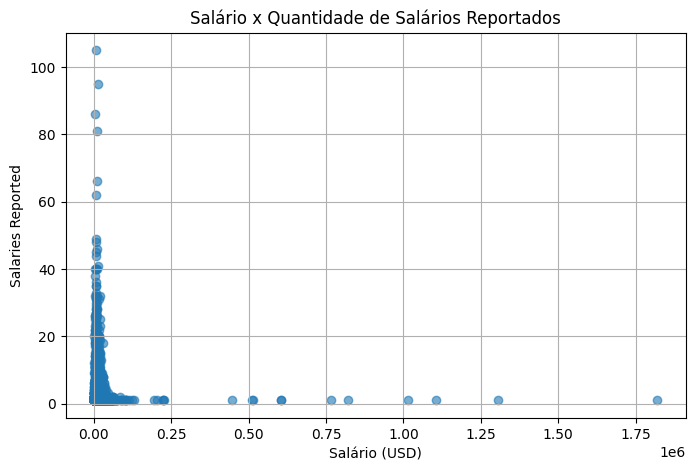

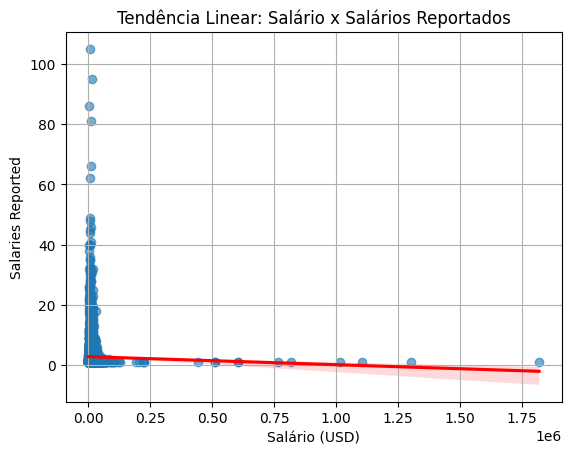

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# One-hot encoding da coluna 'Location'
colunas_categoricas = ["Location"]
df_location = pd.get_dummies(df, columns=colunas_categoricas)

# Aplicar .copy() para evitar SettingWithCopyWarning
#df_location = df_location[df_location["Location_Bangalore"] == 1].copy()

# Verifica se as colunas existem
print(df_location.columns)

# Agora extraia X e Y corretamente do df_location
X = df_location["Salary_usd"]
Y = df_location["Salaries Reported"]

# Gera o scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(X, Y, alpha=0.6)
plt.xlabel("Salário (USD)")
plt.ylabel("Salaries Reported")
plt.title("Salário x Quantidade de Salários Reportados")
plt.grid(True)
plt.show()

import seaborn as sns

sns.regplot(x=X, y=Y, scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})
plt.xlabel("Salário (USD)")
plt.ylabel("Salaries Reported")
plt.title("Tendência Linear: Salário x Salários Reportados")
plt.grid(True)
plt.show()

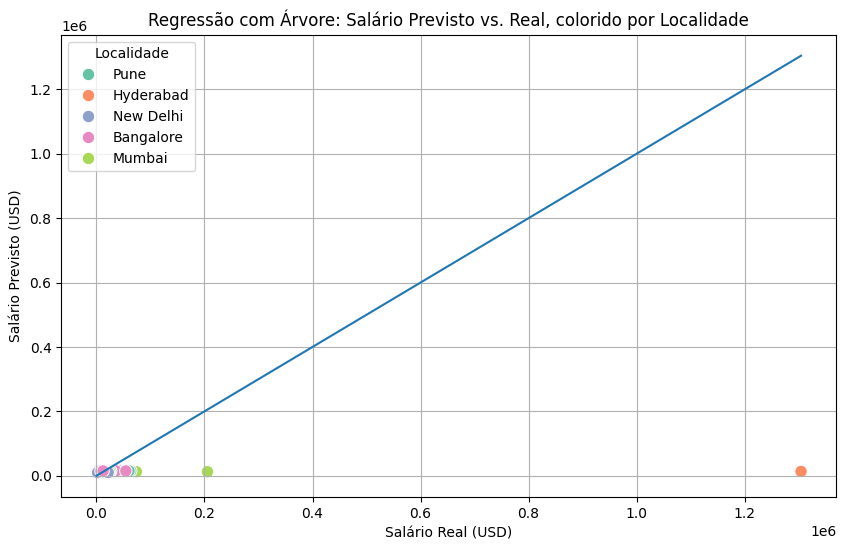

In [72]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Separar variáveis
X = df[["Location"]]
y = df["Salary_usd"]

# Separar os dados antes para manter o Location visível depois
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Codificador para Location
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown='ignore'), ["Location"])
])

# Pipeline de regressão com árvore
pipeline = Pipeline([
    ("pre", preprocessor),
    ("model", DecisionTreeRegressor(max_depth=3, random_state=42))
])

# Treinar modelo
pipeline.fit(X_train_raw, y_train)

# Previsões
y_pred = pipeline.predict(X_test_raw)

# Adicionar Location novamente para visualização
df_resultado = pd.DataFrame({
    "Salário Real": y_test,
    "Salário Previsto": y_pred,
    "Localidade": X_test_raw["Location"].values
})

# Plot com cores por localidade
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_resultado, x="Salário Real", y="Salário Previsto", hue="Localidade", palette="Set2", s=80)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.title("Regressão com Árvore: Salário Previsto vs. Real, colorido por Localidade")
plt.xlabel("Salário Real (USD)")
plt.ylabel("Salário Previsto (USD)")
plt.legend(title="Localidade")
plt.grid(True)
plt.show()


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       700
           1       0.64      0.51      0.57       602

    accuracy                           0.64      1302
   macro avg       0.64      0.63      0.63      1302
weighted avg       0.64      0.64      0.64      1302

Matriz de Confusão:


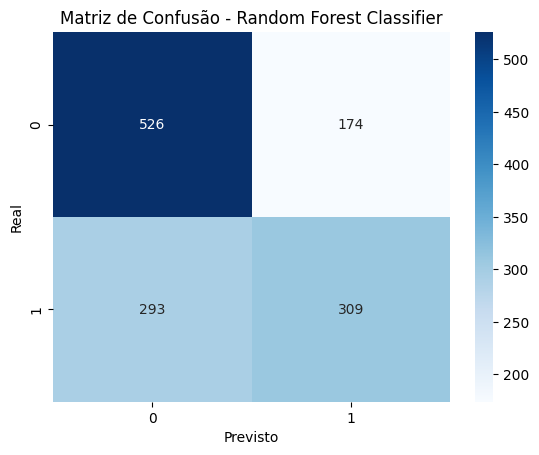

In [74]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Criar a coluna de classificação
df["Salary_Category"] = (df["Salary_usd"] > 9000).astype(int)

# Features e alvo
X = df[["Company Name", "Job Title", "Location", "Salaries Reported"]]
y = df["Salary_Category"]

# One-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predição
y_pred = model.predict(X_test)

# Avaliação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Random Forest Classifier")
plt.show()

